In [1]:
%run heartbeat_slicer.ipynb

In [2]:
import os
import numpy as np
from matplotlib import pyplot as plt

In [3]:
folder_path = "data_processed/mitdb"
record_names_path = "data_original/mitdb/RECORDS"

with open(record_names_path, 'r') as record_names_file:
    record_names = record_names_file.readlines()

record_names = [record_name[:-1] for record_name in record_names]

In [4]:
dataMitDB = []

for record_name in record_names:
    sliced = HeartbeatSlicer(folder_path + '/' + record_name + '_processed')
    dataMitDB.append(sliced.annotate_heartbeats())

In [5]:
#[patient][heartbeat]
dataMitDB[2][3][0].shape

(497,)

In [6]:
time = np.arange(len(dataMitDB[2][3][0]))
point_cloud = np.column_stack([time, dataMitDB[2][3][0]])
listlike = [ [x, y] for (x, y) in point_cloud  ]

In [7]:
listlike

[[0.0, -0.0023076856285664574],
 [1.0, -0.0027090222596214933],
 [2.0, -0.0031103588906765296],
 [3.0, -0.0035116955217315655],
 [4.0, -0.003913032152786601],
 [5.0, -0.004214034626077879],
 [6.0, -0.004515037099369156],
 [7.0, -0.004715705414896674],
 [8.0, -0.0049163737304241915],
 [9.0, -0.005016707888187951],
 [10.0, -0.005016707888187951],
 [11.0, -0.00511704204595171],
 [12.0, -0.005217376203715469],
 [13.0, -0.005418044519242987],
 [14.0, -0.005618712834770505],
 [15.0, -0.006020049465825541],
 [16.0, -0.006521720254644336],
 [17.0, -0.006923056885699372],
 [18.0, -0.007424727674518167],
 [19.0, -0.007826064305573203],
 [20.0, -0.00812706677886448],
 [21.0, -0.008528403409919517],
 [22.0, -0.008929740040974552],
 [23.0, -0.009331076672029589],
 [24.0, -0.009732413303084624],
 [25.0, -0.01013374993413966],
 [26.0, -0.010334418249667179],
 [27.0, -0.010635420722958455],
 [28.0, -0.010735754880722214],
 [29.0, -0.010936423196249732],
 [30.0, -0.011036757354013492],
 [31.0, -0.01123

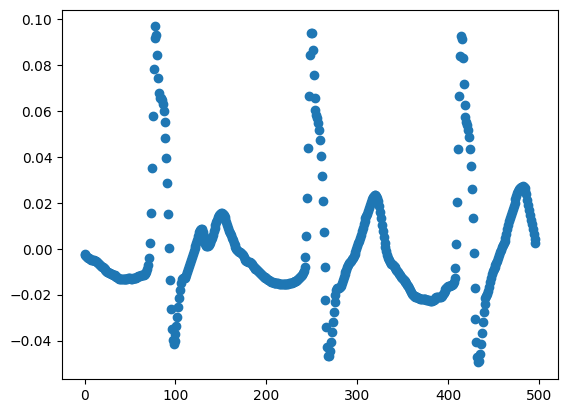

In [8]:
plt.scatter([zez[0] for zez in listlike], [zez[1] for zez in listlike])

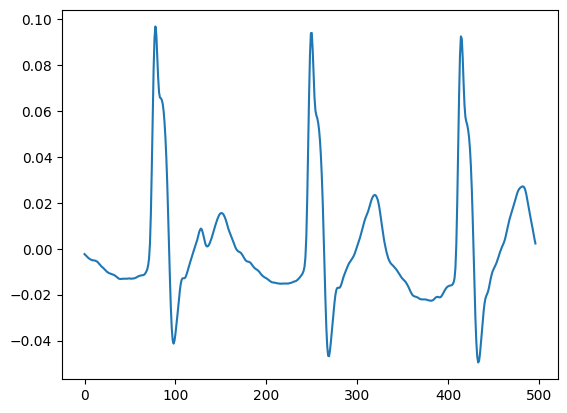

In [9]:
plt.plot([zez[0] for zez in listlike], [zez[1] for zez in listlike])

In [10]:
from matplotlib import pyplot as plt
import gudhi
import gudhi.representations.vector_methods as grvm
import numpy as np

In [11]:
def make_betti_curve(heartbeat):
    # Convert the segment to a point cloud
    # time = np.arange(len(heartbeat))
    # point_cloud = np.column_stack([time, list(dataMitDB[2][2][0])])

    # Compute the Vietoris-Rips complex and its persistence diagram
    rips_complex = gudhi.RipsComplex(points=heartbeat)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    diag = simplex_tree.persistence()

    #plots
    gudhi.plot_persistence_diagram(diag)
    barcode = gudhi.plot_persistence_barcode(diag)

    # # Compute and return Betti curve
    # betti = grvm.BettiCurve(resolution=None)
    # betti.fit([diag])
    # betti_curve = betti.transform([diag])
    # return betti_curve[0]

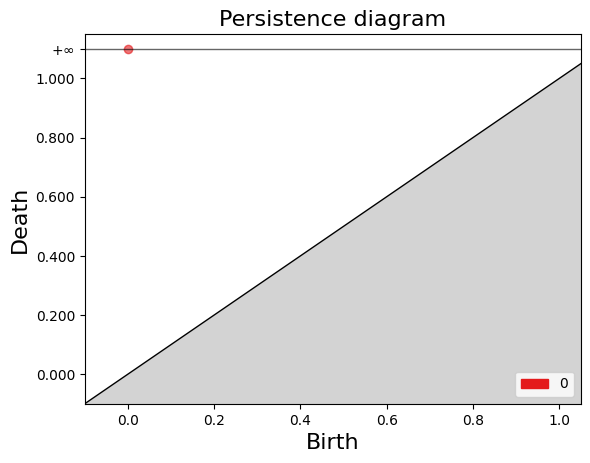

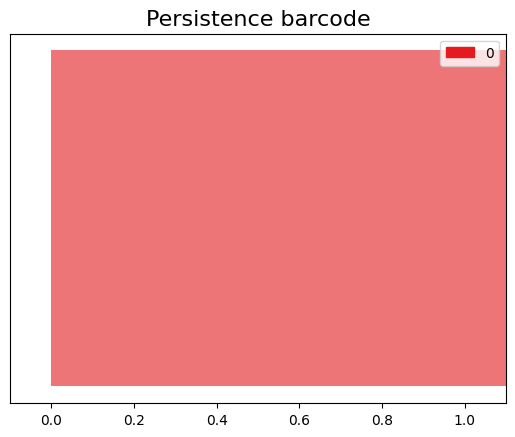

In [14]:
make_betti_curve([dataMitDB[2][3][0]])

In [12]:
type(dataMitDB[2][2][0])

numpy.ndarray

In [15]:
dataMitDB[2][2][0]

array([-0.00722406, -0.00742473, -0.00772573, -0.00802673, -0.00832774,
       -0.0085284 , -0.0085284 , -0.0085284 , -0.00862874, -0.00892974,
       -0.00953174, -0.01033442, -0.01123743, -0.01193976, -0.0126421 ,
       -0.01304344, -0.01344478, -0.01374578, -0.01414712, -0.01444812,
       -0.01484946, -0.01535113, -0.01565213, -0.01595313, -0.0161538 ,
       -0.01625413, -0.0161538 , -0.0161538 , -0.01605347, -0.01605347,
       -0.01595313, -0.01595313, -0.01595313, -0.01595313, -0.01605347,
       -0.0161538 , -0.0161538 , -0.0161538 , -0.0161538 , -0.01605347,
       -0.01605347, -0.01605347, -0.0161538 , -0.01625413, -0.0164548 ,
       -0.01665547, -0.01665547, -0.0164548 , -0.01595313, -0.01525079,
       -0.01454845, -0.01394645, -0.01354511, -0.01344478, -0.01354511,
       -0.01374578, -0.01374578, -0.01354511, -0.01294311, -0.0120401 ,
       -0.01053509, -0.00812707, -0.00280936,  0.00832774,  0.02638788,
        0.04826073,  0.06923057,  0.08458169,  0.09140442,  0.08